In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
70586,Yoshinori_Muto,5,4,23,Newcastle United,Liverpool,0.587511,2.297819,False,1,1920,1.0
70587,Youri_Tielemans,5,3,90,Leicester City,Manchester United,0.881009,1.617600,False,2,1920,1.0
70588,Yves_Bissouma,5,3,0,Brighton and Hove Albion,Burnley,0.466221,0.426814,True,0,1920,0.5
70589,Çaglar_Söyüncü,5,2,90,Leicester City,Manchester United,0.881009,1.617600,False,2,1920,1.0
70590,Ørjan_Nyland,5,1,0,Aston Villa,West Ham United,0.410171,0.748939,True,0,1920,1.0


In [5]:
train_df.shape

(70591, 12)

In [6]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [7]:
train_df.shape

(70591, 12)

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 6)].index.min()
valid_end = train_df.index.max()

In [9]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
season                                  object
play_proba                             float64
dtype: object

In [10]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [11]:
# set dependent variable
dep_var = 'total_points'

In [12]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [16]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1035, 78)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(28, 10)
    (4): Embedding(27, 10)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=124, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


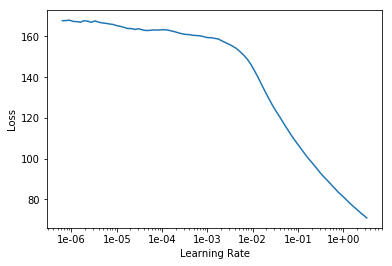

In [23]:
learn.recorder.plot()

In [24]:
# no market value, latest half season validation
learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.501507,7.926478,2.782442,00:02
1,7.460577,8.293941,2.840935,00:02
2,6.654506,7.472949,2.700373,00:02


In [43]:
# market value, latest half season validation
learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [18]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.839948,3.946950,1.950727,00:15
1,3.297435,3.570805,1.843542,00:05


In [19]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.217666,3.569093,1.846443,00:05


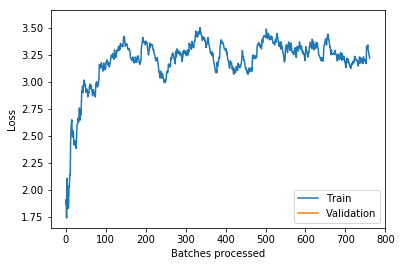

In [20]:
learn.recorder.plot_losses()

In [21]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [22]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba,predicted_points
52476,Oumar_Niasse,12,4,0,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.021111
63316,Alex_Smithies,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.081209
63354,Anthony_Pilkington,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.108160
63363,Aron_Gunnarsson,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,NaN,3.353987
63367,Ashley Darel Jazz_Richards,32,2,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.043223
63408,Bobby_Reid,32,4,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.293705
63414,Brian_Murphy,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.012377
63418,Bruno_Ecuele Manga,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,1819,NaN,1.623178
63425,Callum_Paterson,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.152688
63493,Danny_Ward_2,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,1819,NaN,0.019560


In [23]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba,predicted_points
52450,Mohamed_Salah,12,3,90,Liverpool,Fulham,2.177887,0.405284,True,8,1819,NaN,9.153277
51349,Mohamed_Salah,10,3,90,Liverpool,Cardiff City,2.177887,0.183890,True,15,1819,NaN,8.902070
49177,Mohamed_Salah,6,3,90,Liverpool,Southampton,2.177887,0.654624,True,8,1819,NaN,8.722469
68308,Mohamed_Salah,1,3,90,Liverpool,Norwich,2.297572,0.198300,True,12,1920,1.0,8.591887
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,1819,NaN,8.504167
61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,1819,NaN,8.469259
52529,Sadio_Mané,12,3,90,Liverpool,Fulham,2.177887,0.405284,True,3,1819,NaN,8.441314
53332,Eden_Hazard,14,3,90,Chelsea,Fulham,2.540586,0.405284,True,6,1819,NaN,8.322315
50086,Harry_Kane,8,4,90,Tottenham Hotspur,Cardiff City,1.983109,0.183890,True,1,1819,NaN,8.260648
63486,Danilo Luiz_da Silva,32,2,90,Manchester City,Cardiff City,2.540586,0.183890,True,8,1819,NaN,8.256142


In [24]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.890548229217529

In [25]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])

5.512

In [26]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [27]:
remaining_season_df.head(50)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,6,Southampton,Bournemouth,Jannik_Vestergaard,2,5.1,1.0,True,0.508956,0.717800,1920,90.000000
1,6,Southampton,Bournemouth,Ryan_Bertrand,2,4.9,1.0,True,0.508956,0.717800,1920,0.000000
2,6,Southampton,Bournemouth,Yan_Valery,2,4.9,1.0,True,0.508956,0.717800,1920,17.333333
3,6,Southampton,Bournemouth,Jan_Bednarek,2,4.5,1.0,True,0.508956,0.717800,1920,90.000000
4,6,Southampton,Bournemouth,Jack_Stephens,2,4.4,1.0,True,0.508956,0.717800,1920,0.000000
5,6,Southampton,Bournemouth,Maya_Yoshida,2,4.4,1.0,True,0.508956,0.717800,1920,34.333333
6,6,Southampton,Bournemouth,Kayne_Ramsay,2,4.0,1.0,True,0.508956,0.717800,1920,0.000000
7,6,Southampton,Bournemouth,Charlie_Austin,4,6.0,0.0,True,0.508956,0.717800,1920,0.000000
8,6,Southampton,Bournemouth,Danny_Ings,4,6.0,1.0,True,0.508956,0.717800,1920,58.333333
9,6,Southampton,Bournemouth,Michael_Obafemi,4,5.0,1.0,True,0.508956,0.717800,1920,0.000000


In [28]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [29]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [30]:
# train as before
learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [31]:
learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [32]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [33]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.2599568367004395

In [34]:
remaining_season_df.shape

(17787, 13)

In [38]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
2239,14,Liverpool,Brighton and Hove Albion,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.466221,1920,90.0,10.178487
3102,17,Liverpool,Watford,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.504983,1920,90.0,9.950230
137,6,Manchester City,Watford,Sergio_Agüero,4,12.1,1.0,True,2.748793,0.504983,1920,90.0,9.560143
5797,27,Liverpool,West Ham United,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.748939,1920,90.0,9.531730
141,6,Manchester City,Watford,Raheem_Sterling,3,12.3,1.0,True,2.748793,0.504983,1920,90.0,9.484307
6822,31,Liverpool,Crystal Palace,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.507990,1920,90.0,9.265383
5536,26,Manchester City,West Ham United,Sergio_Agüero,4,12.1,1.0,True,2.748793,0.748939,1920,90.0,9.227734
5540,26,Manchester City,West Ham United,Raheem_Sterling,3,12.3,1.0,True,2.748793,0.748939,1920,90.0,9.084765
7361,33,Liverpool,Aston Villa,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.410171,1920,90.0,9.063287
6336,29,Liverpool,Bournemouth,Mohamed_Salah,3,12.5,1.0,True,2.297819,0.717800,1920,90.0,8.942044


In [39]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')